# 🎤 Emotion Recognition using Vision Transformer
This notebook walks through audio emotion recognition using mel spectrograms and a fine-tuned ViT model.

We demonstrate preprocessing, model training, and real-world emotion inference.

## Mel Spectrogram Conversion
We convert raw `.wav` audio files into mel spectrogram images, which serve as input to our vision-based model.

In [ ]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Path to audio files
input_base_path = "/content/drive/MyDrive/Colab Notebooks/emotions"

# Output path for spectrograms
output_base_path = "/content/drive/MyDrive/Colab Notebooks/mel_spectrograms"
os.makedirs(output_base_path, exist_ok=True)



#Function to convert
def save_mel_spectrogram(audio_path, output_path):
    y, sr = librosa.load(audio_path, sr=16000)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_DB = librosa.power_to_db(S, ref=np.max)

    plt.figure(figsize=(3, 3))
    librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
    plt.close()



#Loop through all files to convert
for emotion_folder in os.listdir(input_base_path):
    folder_path = os.path.join(input_base_path, emotion_folder)

    if os.path.isdir(folder_path):
        output_emotion_dir = os.path.join(output_base_path, emotion_folder)
        os.makedirs(output_emotion_dir, exist_ok=True)

        for file in tqdm(os.listdir(folder_path), desc=f"Processing {emotion_folder}"):
            if file.endswith(".wav"):
                input_audio_path = os.path.join(folder_path, file)
                output_img_path = os.path.join(output_emotion_dir, file.replace(".wav", ".png"))
                save_mel_spectrogram(input_audio_path, output_img_path)


Processing Angry: 100%|██████████| 1/1 [00:00<00:00, 16448.25it/s]



## Audio to Image Conversion Using Mel Spectrograms

This section converts raw audio (`.wav`) into mel spectrogram images (`.png`) to be used as input for a vision-based deep learning model.

### Why We Convert Audio to Images
Raw audio is a 1D signal, unsuitable for image models like ViT. A mel spectrogram visually represents frequency over time, with color intensity showing loudness. It enables use of computer vision models on audio.

### Breakdown of `save_mel_spectrogram()`

```python
y, sr = librosa.load(audio_path, sr=16000)
```
- Loads the waveform and resamples it to 16kHz — a common speech rate, efficient for computation.

```python
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
```
- Computes mel-scaled spectrogram with 128 frequency bins — detailed enough for emotion, compact for modeling.

```python
S_DB = librosa.power_to_db(S, ref=np.max)
```
- Converts power values to decibels to mimic human hearing and enhance differences.

```python
librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
```
- Renders the spectrogram using a perceptually uniform color map for better learning.

```python
plt.axis('off')
plt.tight_layout()
plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
```
- Saves a clean image, removing axis labels and padding — ideal for deep learning input.

### Why This Setup Works

| Design Choice      | Reason |
|--------------------|--------|
| Mel scale          | Mimics human auditory perception |
| 128 mel bins       | Balanced feature granularity |
| dB conversion      | Expands dynamic range for better learning |
| 16kHz sample rate  | Focuses on speech range, reduces size |
| Clean .png output  | Directly usable for ViT model |

Every `.wav` becomes a clean, standardized `.png` for emotion classification.


**Image Dataset and Dataloader Setup**

In [25]:
import os
from torchvision import datasets
from sklearn.model_selection import train_test_split, StratifiedKFold

# Dataset directory
spectrogram_dir = "/content/drive/MyDrive/Colab Notebooks/mel_spectrograms"

# Use ImageFolder to get file paths and labels
base_dataset = datasets.ImageFolder(root=spectrogram_dir)
image_paths = [sample[0] for sample in base_dataset.samples]
labels = [sample[1] for sample in base_dataset.samples]

# Check class mapping
label_to_class = base_dataset.classes
print("Class Labels:", label_to_class)

Class Labels: ['Angry', 'Calm', 'Disgust', 'Fearful', 'Happy', 'Neutral', 'Sad', 'Surprised']



## Organizing Dataset with ImageFolder

We use `torchvision.datasets.ImageFolder` to automatically assign labels based on folder names.

```python
base_dataset = datasets.ImageFolder(root=spectrogram_dir)
image_paths = [sample[0] for sample in base_dataset.samples]
labels = [sample[1] for sample in base_dataset.samples]
```

- `ImageFolder` treats each subdirectory (e.g., "Angry", "Happy") as a class.
- `samples` returns a list of `(filepath, label)` pairs.
- We extract paths and corresponding labels for custom dataset usage.


## Dataset Preparation
We use a custom PyTorch Dataset to handle spectrogram images and apply necessary transforms for ViT.

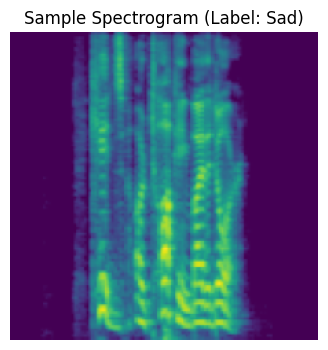

In [ ]:
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Change to 3x channels if RGB
])

class SpectrogramDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

import matplotlib.pyplot as plt

# Visualize what the dataset returns
sample_ds = SpectrogramDataset(image_paths=image_paths, labels=labels, transform=transform)
sample_img, sample_label = sample_ds[0]

# Convert tensor back to displayable image
img_display = sample_img.permute(1, 2, 0).numpy()
img_display = (img_display * 0.5 + 0.5).clip(0, 1)  # Un-normalize from [-1, 1]

plt.figure(figsize=(4, 4))
plt.imshow(img_display)
plt.title(f"Sample Spectrogram (Label: {label_to_class[sample_label]})")
plt.axis("off")
plt.show()


## Custom Dataset Class with Transformations

We define a PyTorch `Dataset` to load spectrogram images and apply necessary transforms.

```python
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
```

- Resizes the image to 224x224 (required by ViT).
- Converts the image to tensor format (C, H, W).
- Normalizes pixel values to [-1, 1].

```python
class SpectrogramDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        ...
```

- Loads image from disk and applies transform.
- Returns image and label pair for training/validation.


## Vision Transformer Model
We use Hugging Face's `ViTForImageClassification` and load pretrained weights.


## Vision Transformer (ViT) Model Setup

We use a pretrained ViT model from Hugging Face for image classification.

```python
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=len(label_to_class),
    ignore_mismatched_sizes=True
)
```

- Loads pretrained weights trained on ImageNet.
- `ignore_mismatched_sizes=True` lets us replace the classifier head to fit 8 emotion classes.
- ViT is suitable because spectrograms are structured like images.


In [27]:
from transformers import ViTForImageClassification, ViTFeatureExtractor
import torch

# Load pretrained ViT model & feature extractor
model_name = "google/vit-base-patch16-224"

feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(label_to_class),  # Set to number of emotion classes
    ignore_mismatched_sizes=True  # In case head layer shape is mismatched
)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

## Hyperparameter Tuning with Optuna
We use Optuna to find the best learning rate, batch size, and optimizer.

In [ ]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, accuracy_score, f1_score
from transformers import ViTForImageClassification

def objective(trial):
    # Sample hyperparameters
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-4)
    weight_decay = trial.suggest_uniform('weight_decay', 0.0, 0.3)
    optimizer_name = trial.suggest_categorical('optimizer', ['AdamW', 'Adam'])
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])
    num_epochs = 3

    X_train, X_test, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, stratify=labels, random_state=18)
    train_ds = SpectrogramDataset(X_train, y_train, transform)
    val_ds = SpectrogramDataset(X_test, y_test, transform)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    # Optimizer
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    else:
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    criterion = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            outputs = model(pixel_values=images).logits
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            outputs = model(pixel_values=images).logits
            preds = torch.argmax(outputs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Compute metrics
    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average='macro')

    # Combined score (equal weight)
    score = 0.5 * acc + 0.5 * macro_f1

    # Optional: log the trial metrics
    trial.set_user_attr("accuracy", acc)
    trial.set_user_attr("macro_f1", macro_f1)

    return score


In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15)
print("Best Trial:")
print(f"  Score: {study.best_value:.4f}")
print(f"  Params: {study.best_trial.params}")
print(f"  Accuracy: {study.best_trial.user_attrs['accuracy']:.4f}")
print(f"  Macro F1: {study.best_trial.user_attrs['macro_f1']:.4f}")


[I 2025-04-19 19:35:39,575] A new study created in memory with name: no-name-2af40517-814c-4b64-9ad6-72b3b4be2829
<ipython-input-22-591a7d816a59>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-4)
<ipython-input-22-591a7d816a59>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  weight_decay = trial.suggest_uniform('weight_decay', 0.0, 0.3)
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model inst

Best Trial:
  Score: 0.6737
  Params: {'learning_rate': 4.977087189822422e-05, 'weight_decay': 0.22525804367208868, 'optimizer': 'AdamW', 'batch_size': 16}
  Accuracy: 0.6743
  Macro F1: 0.6730


In [29]:
best_params = {
    'learning_rate': 4.977087189822422e-05,
    'weight_decay': 0.22525804367208868,
    'optimizer_name': 'AdamW',
    'batch_size': 16,
    'num_epochs': 10
}


## Final Model Training
We train a final model using the best hyperparameters found.

In [30]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification
import torch.nn as nn
import torch.optim as optim

X_train, X_test, y_train, y_test = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=18
)
train_ds = SpectrogramDataset(X_train, y_train, transform)
val_ds = SpectrogramDataset(X_test, y_test, transform)

train_loader = DataLoader(train_ds, batch_size=best_params['batch_size'], shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=best_params['batch_size'], shuffle=False, num_workers=2, pin_memory=True)

if best_params['optimizer_name'] == 'AdamW':
    optimizer = optim.AdamW(
        model.parameters(),
        lr=best_params['learning_rate'],
        weight_decay=best_params['weight_decay']
    )
else:
    optimizer = optim.Adam(
        model.parameters(),
        lr=best_params['learning_rate'],
        weight_decay=best_params['weight_decay']
    )


criterion = nn.CrossEntropyLoss()


for epoch in range(best_params['num_epochs']):
    model.train()
    running_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(pixel_values=images).logits
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    print(f"Epoch {epoch+1}: Loss = {running_loss:.4f}, Accuracy = {acc:.2f}%")


Epoch 1: Loss = 193.4399, Accuracy = 38.60%
Epoch 2: Loss = 113.7029, Accuracy = 66.85%
Epoch 3: Loss = 53.6627, Accuracy = 85.62%
Epoch 4: Loss = 22.0779, Accuracy = 94.80%
Epoch 5: Loss = 8.4148, Accuracy = 98.32%
Epoch 6: Loss = 5.8301, Accuracy = 98.62%
Epoch 7: Loss = 0.8061, Accuracy = 100.00%
Epoch 8: Loss = 0.3450, Accuracy = 100.00%
Epoch 9: Loss = 0.2441, Accuracy = 100.00%
Epoch 10: Loss = 0.1977, Accuracy = 100.00%


<Figure size 800x600 with 0 Axes>

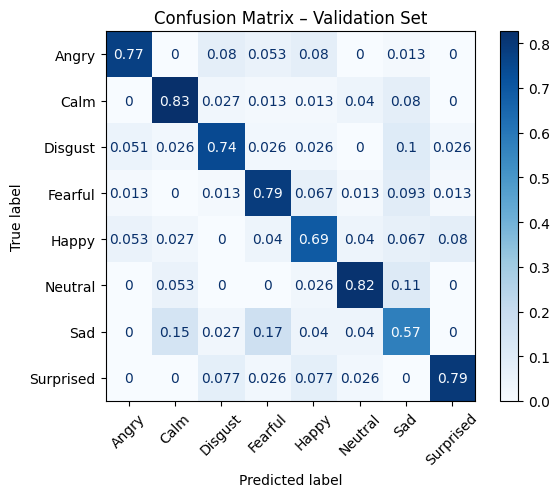

Validation Results:
              precision    recall  f1-score   support

       Angry       0.89      0.77      0.83        75
        Calm       0.79      0.83      0.81        75
     Disgust       0.67      0.74      0.71        39
     Fearful       0.72      0.79      0.75        75
       Happy       0.72      0.69      0.71        75
     Neutral       0.74      0.82      0.78        38
         Sad       0.61      0.57      0.59        75
   Surprised       0.79      0.79      0.79        39

    accuracy                           0.74       491
   macro avg       0.74      0.75      0.75       491
weighted avg       0.75      0.74      0.74       491



In [31]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(pixel_values=images).logits
        preds = torch.argmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_to_class))

plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix – Validation Set")
plt.show()
print("Validation Results:")
print(classification_report(y_true, y_pred, target_names=label_to_class))



## Model Evaluation with Accuracy, F1 Score, and Confusion Matrix

After training, we evaluate the model’s performance on validation data.

```python
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
```

- We use accuracy and macro F1 to capture balanced class-wise performance.
- A confusion matrix shows how predictions align with true labels across all classes.
- Misclassifications (e.g., "Happy" → "Angry") reveal model limitations.


In [32]:
torch.save(model.state_dict(), "/content/drive/MyDrive/vit_emotion_final_model.pt")
print("✅ Final model saved to Google Drive!")


✅ Final model saved to Google Drive!


## Emotion Testing – Natural vs Acted Speech
We test the model on real recorded speech using both natural tone and performed (acted) tone.

In [35]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
def save_mel_spectrogram(audio_path, output_path):
    y, sr = librosa.load(audio_path, sr=16000)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_DB = librosa.power_to_db(S, ref=np.max)

    plt.figure(figsize=(3, 3))
    librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
    plt.close()
test_img = save_mel_spectrogram("/content/happy_natural.wav","/content/your_test_spectrogram.png")
from PIL import Image
import matplotlib.pyplot as plt
def show_comparison(your_img_path, actor_img_path, emotion="Emotion"):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    your_img = Image.open(your_img_path)
    actor_img = Image.open(actor_img_path)

    axs[0].imshow(your_img, cmap='magma')
    axs[0].set_title("Natural Spectrogram")
    axs[0].axis('off')

    axs[1].imshow(actor_img, cmap='magma')
    axs[1].set_title(f"Acted Spectrogram")
    axs[1].axis('off')

    plt.suptitle(f"Mel Spectrogram Comparison – {emotion}")
    plt.tight_layout()
    plt.show()


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🧍 Natural Tone Prediction: Disgust
🎭 Acted Tone Prediction: Happy


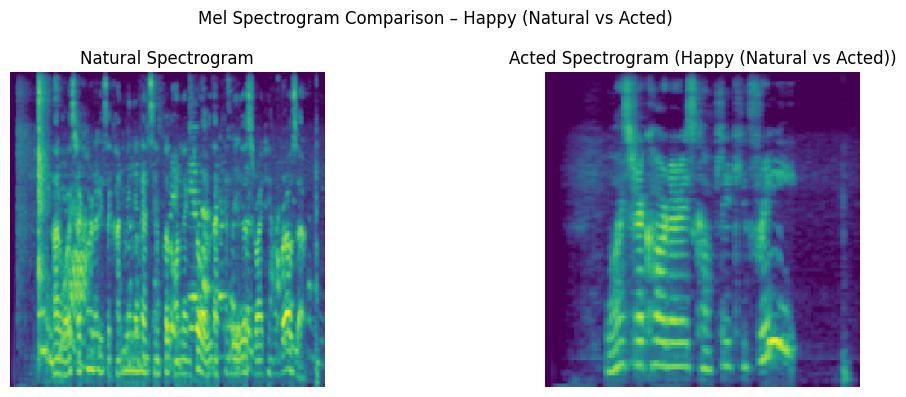

In [ ]:
from google.colab import files
def convert_to_mel_spectrogram(audio_path, output_size=(224, 224)):
    y, sr = librosa.load(audio_path, sr=22050)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_db = librosa.power_to_db(mel, ref=np.max)

    mel_img = Image.fromarray(
        ((mel_db - mel_db.min()) / (mel_db.max() - mel_db.min()) * 255).astype(np.uint8)
    ).convert("L")  # still grayscale at this point

    mel_img = mel_img.resize(output_size).convert("RGB")  # now 3-channel
    return mel_img

import torch
from torchvision import transforms

def predict_emotion(image, model, device):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])  # Grayscale normalization
    ])

    input_tensor = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(pixel_values=input_tensor).logits
        pred = torch.argmax(outputs, dim=1).item()

    return label_to_class[pred]
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=len(label_to_class),
    ignore_mismatched_sizes=True
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.load_state_dict(torch.load(
    "/content/drive/MyDrive/vit_emotion_final_model_happy.pt",
    map_location=device  # 👈 ensures compatibility with CPU or GPU
))
model.to(device)
files.upload()
img_natural = save_mel_spectrogram("Happy_Test.wav","/content/natural_happy.png")
img_acted = save_mel_spectrogram("Happy_RAVDESS.wav","/content/acted_happy.png")
img_natural=convert_to_mel_spectrogram("Happy_Test.wav")
img_acted=convert_to_mel_spectrogram("Happy_RAVDESS.wav")
pred_natural = predict_emotion(img_natural, model, device)
pred_acted = predict_emotion(img_acted, model, device)

print("🧍 Natural Tone Prediction:", pred_natural)
print("🎭 Acted Tone Prediction:", pred_acted)
show_comparison("natural_happy.png", "acted_happy.png", emotion="Happy (Natural vs Acted)")




## Real-World Emotion Testing – Natural vs Acted Speech

We test the model on self-recorded `.wav` files for each emotion in both:
- Natural tone (as spoken casually)
- Acted tone (mimicking RAVDESS style)

```python
pred_natural = predict_emotion(mel_img_natural, model, device)
pred_acted = predict_emotion(mel_img_acted, model, device)
```

- Predictions often fail on natural tones due to mismatch with training data.
- Shows the importance of training with diverse, real-world audio samples.
